In [18]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

# Load and prepare datasets
new_df = pd.read_csv(r'G:\learn\python_works\google_ee\rudra\datas\attatchments\discharge_data_from_internet.csv')
new_df['Month'] = new_df['Month'].map(month_map)
new_df = new_df.rename(columns={'Discharge (m3/s)': 'Discharge'})

df = pd.read_csv('bias_corrected_discharge_with_trend.csv', usecols=['Year', 'Month', 'another_Bias_Corrected_Discharge'])
df = df.rename(columns={'another_Bias_Corrected_Discharge': 'Discharge'})

# Combine datasets for clarity
new_df['Source'] = 'Observed'
df['Source'] = 'Model'
combined = pd.concat([new_df, df], ignore_index=True)

# Identify missing years
existing_years = set(df['Year'].unique())
observed_years = set(new_df['Year'].unique())
missing_years = list(observed_years - existing_years)

# Create training set using df (model-based)
train = df.copy()
X_train = train[['Year', 'Month']]
y_train = train['Discharge']

# Create prediction set for missing years
predict_set = new_df[new_df['Year'].isin(missing_years)].copy()
X_pred = predict_set[['Year', 'Month']]

# Train model
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Predict missing discharge
predict_set['Predicted_Discharge'] = model.predict(X_pred)

# Merge predicted values to df
improved_df = pd.concat([df, predict_set[['Year', 'Month', 'Predicted_Discharge']].rename(columns={'Predicted_Discharge': 'Discharge'})], ignore_index=True)
improved_df = improved_df.sort_values(['Year', 'Month']).reset_index(drop=True)


In [22]:
new_df

,Year,Month,Discharge,Source
0,1963,1,1.17,Observed
1,1964,1,1.47,Observed
2,1965,1,1.32,Observed
3,1966,1,1.60,Observed
4,1967,1,1.09,Observed
...,...,...,...,...
175,1973,12,2.74,Observed
176,1974,12,1.50,Observed
177,1975,12,1.67,Observed
178,1976,12,1.45,Observed


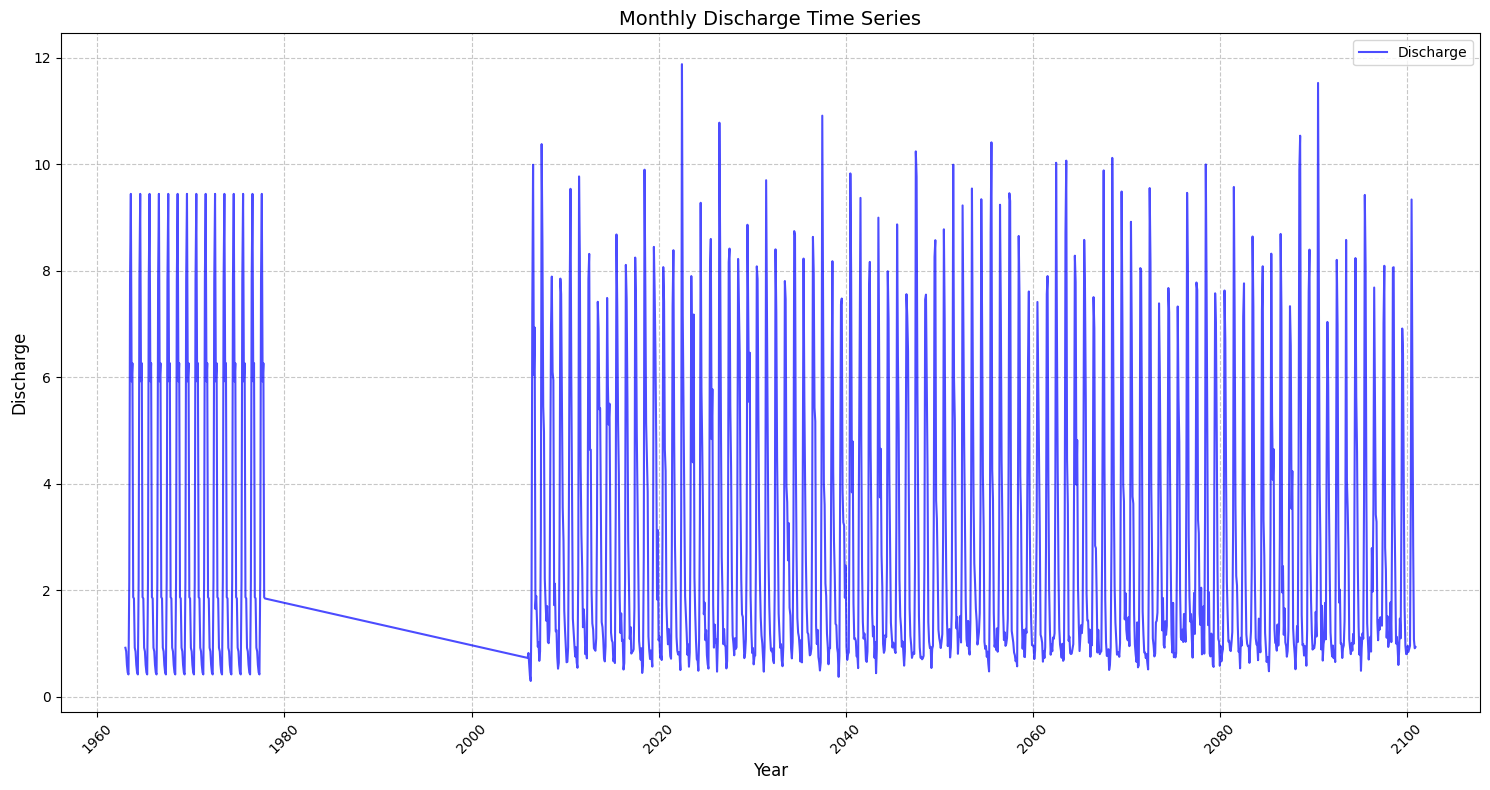


Discharge Statistics:
Time Period: 1963 to 2100
Mean Discharge: 2.93
Max Discharge: 11.88
Min Discharge: 0.30


In [21]:
import matplotlib.pyplot as plt
import pandas as pd

# Create figure and axis
plt.figure(figsize=(15, 8))

# Convert Year and Month to datetime for better x-axis representation
improved_df['Date'] = pd.to_datetime(improved_df[['Year', 'Month']].assign(Day=1))

# Plot the data
plt.plot(improved_df['Date'], improved_df['Discharge'], 
         'b-', label='Discharge', alpha=0.7)

# Customize the plot
plt.title('Monthly Discharge Time Series', fontsize=14)
plt.xlabel('Year', fontsize=12)
plt.ylabel('Discharge', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend(fontsize=10)

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)

# Adjust layout to prevent label cutoff
plt.tight_layout()

# Display the plot
plt.show()

# Print basic statistics
print("\nDischarge Statistics:")
print(f"Time Period: {improved_df['Date'].min().year} to {improved_df['Date'].max().year}")
print(f"Mean Discharge: {improved_df['Discharge'].mean():.2f}")
print(f"Max Discharge: {improved_df['Discharge'].max():.2f}")
print(f"Min Discharge: {improved_df['Discharge'].min():.2f}")

c:\ProgramData\anaconda3\envs\code_paper\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\ProgramData\anaconda3\envs\code_paper\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


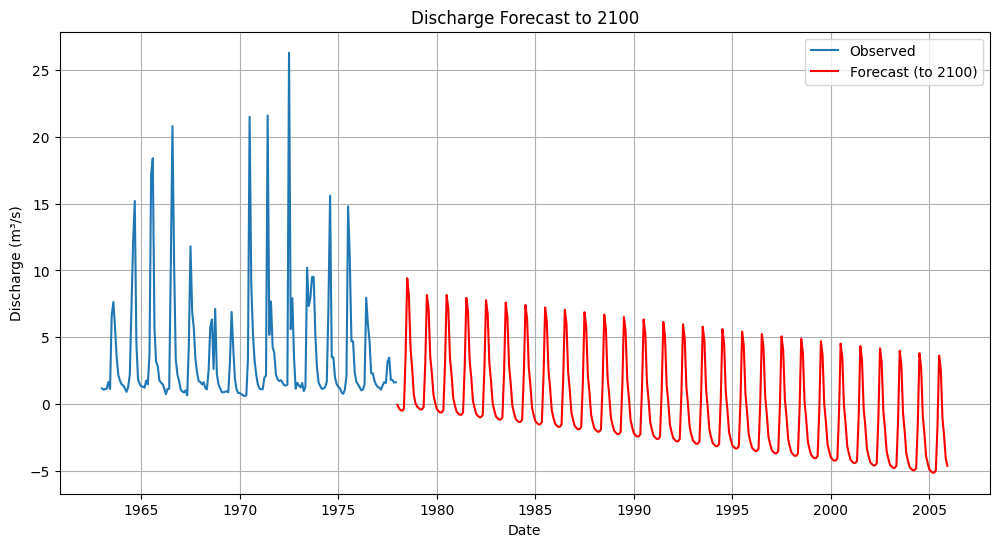

In [23]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Load data
df = pd.read_csv(r'G:\learn\python_works\google_ee\rudra\datas\attatchments\discharge_data_from_internet.csv')
df['Month'] = df['Month'].map(month_map)
df['Date'] = pd.to_datetime(df['Year'].astype(str) + '-' + df['Month'].astype(str) + '-01')
df = df.sort_values('Date')
df.set_index('Date', inplace=True)
df['Month'] = df['Month'].map(month_map)
df = df.rename(columns={'Discharge (m3/s)': 'Discharge'})

# Only keep the Discharge column
ts = df['Discharge']

# Fit SARIMA model (adjust order if needed)
model = SARIMAX(ts, order=(1, 1, 1), seasonal_order=(1, 1, 1, 12))
results = model.fit(disp=False)

# Forecast until 2100
forecast_steps = (2005 - ts.index[-1].year) * 12  # forecast monthly to 2100
forecast = results.get_forecast(steps=forecast_steps)
forecast_index = pd.date_range(start=ts.index[-1] + pd.DateOffset(months=1), periods=forecast_steps, freq='MS')
forecast_series = pd.Series(forecast.predicted_mean.values, index=forecast_index)

# Plot
plt.figure(figsize=(12, 6))
plt.plot(ts, label='Observed')
plt.plot(forecast_series, label='Forecast (to 2100)', color='red')
plt.xlabel('Date')
plt.ylabel('Discharge (m³/s)')
plt.title('Discharge Forecast to 2100')
plt.legend()
plt.grid(True)
plt.show()
